<a href="https://colab.research.google.com/github/Callum-Roberts713/MiscPythonCode/blob/main/MLE_transition_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def RMSDEV(A,B):
    diff2=(np.array(A)-np.array(B))**2
    return(np.sqrt(diff2.sum()/len(diff2)))

In [ ]:
#Labelled transitions from Table VI of Minzhong Xu, Francesco Sebastianelli, and Zlatko Bačić THE JOURNAL OF CHEMICAL PHYSICS 128, 244715 (2008)
labelled_trans=[73.0,75.9,98.0,159.3, 160.2, 173.3, 181.9, 184.1, 219.4]
labelled_qnumbers=[[1,0,0],[0,1,0],[0,0,1],[2,0,0],[1,1,0],[1,0,1],[0,2,0],[0,1,1],[0,0,2]]

In [ ]:
def Ebox(Lx,Ly,Lz,nx,ny,nz):
    Lx=1.889725989*Lx
    Ly=1.889725989*Ly
    Lz=1.889725989*Lz
    h=2*np.pi
    m=2*(1.0078)*1.82289*10**3
    htocm=219474.63
    return(htocm*(h**2/(8*m))*((nx**2)/(Lx**2)+(ny**2)/(Ly**2)+(nz**2)/(Lz**2)))

#GROUND STATE IN PBOX IS (1,1,1) !!
def fund_transition_PB3D_vec(Lx,Ly,Lz,fn):
    trans_cal=[]
    for element in fn:
        trans_cal.append(Ebox(Lx,Ly,Lz,element[0]+1,element[1]+1,element[2]+1)-Ebox(Lx,Ly,Lz,1,1,1))
    return(trans_cal)

In [ ]:
import scipy.stats as stats
from scipy.optimize import minimize

#new reg
def dataMLEreg_PB_Lasso(params):
    Lx, Ly, Lz, sd,xes,data = params[0], params[1] , params[2], params[3],params[4],params[5]# inputs are guesses at our parameters

# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
    #xes is a list of three quantum numbers
    yhat = fund_transition_PB3D_vec(Lx,Ly,Lz,xes) # predictions

    # next, we flip the Bayesian question
# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(data, loc=yhat, scale=sd) )
# return negative LL return(negLL)
    return(negLL)

In [ ]:
newfun=lambda x : dataMLEreg_PB_Lasso([x[0],x[1],x[2],.1,labelled_qnumbers,labelled_trans])
guess = np.array([1, 1,1])
resultsPB = minimize(newfun, guess, method = 'Nelder-Mead', options={'disp': True})
print(resultsPB)

Optimization terminated successfully.
         Current function value: 107985.097058
         Iterations: 77
         Function evaluations: 137
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 107985.09705821768
             x: [ 1.936e+00  1.827e+00  1.668e+00]
           nit: 77
          nfev: 137
 final_simplex: (array([[ 1.936e+00,  1.827e+00,  1.668e+00],
                       [ 1.936e+00,  1.827e+00,  1.668e+00],
                       [ 1.936e+00,  1.827e+00,  1.668e+00],
                       [ 1.936e+00,  1.827e+00,  1.668e+00]]), array([ 1.080e+05,  1.080e+05,  1.080e+05,  1.080e+05]))


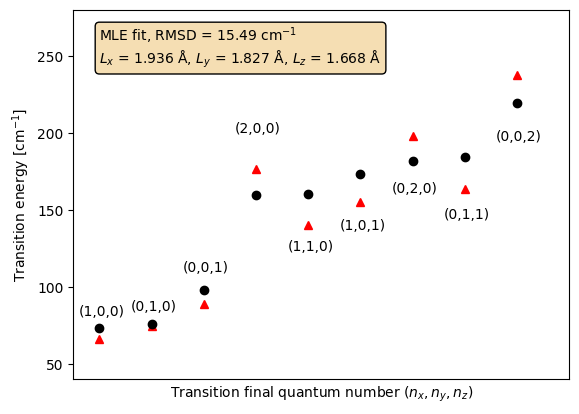

In [ ]:
f = plt.figure()
ypred=fund_transition_PB3D_vec(resultsPB.x[0],resultsPB.x[1],resultsPB.x[2],labelled_qnumbers)
plt.plot(ypred,'r^')
plt.ylim(40,280)
plt.xlim(-0.5,len(labelled_qnumbers))
plt.xticks([], [])
plt.plot(labelled_trans,'ko')
plt.ylabel('Transition energy [cm$^{-1}$]')
plt.xlabel('Transition final quantum number $(n_x,n_y,n_z)$')
textstr = '\n'.join((
    r'MLE fit, RMSD = %.2f cm$^{-1}$'%RMSDEV(ypred,labelled_trans),
    r'$L_x$ = %.3f Å, $L_y$ = %.3f Å, $L_z$ = %.3f Å'%(resultsPB.x[0],resultsPB.x[1],resultsPB.x[2])))

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

plt.text(0,270, textstr,
        verticalalignment='top', bbox=props)

ts=0
for lab in labelled_qnumbers:
    if(ts<4):
        plt.annotate('(%d,%d,%d)'%(lab[0],lab[1],lab[2]),xy=(ts,ypred[ts]*1.1), xytext=(ts-0.4,max(ypred[ts],labelled_trans[ts])*1.15), va='center')
    else:
        plt.annotate('(%d,%d,%d)'%(lab[0],lab[1],lab[2]),xy=(ts,ypred[ts]*.9), xytext=(ts-0.4,min(ypred[ts],labelled_trans[ts])*.9), va='center')
    ts+=1

plt.show()
f.savefig("H2_pbox_fit.pdf", bbox_inches='tight')